In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import pygeos
import osmnx as ox
import shapely as shp
from ast import literal_eval
from pyproj import Geod
import matplotlib.pyplot as plt
import folium

C:\Users\yianz\AppData\Local\Temp\ipykernel_9452\3262555724.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# Census tracts in NYC 
tracts = gpd.read_file('./data/new_york_census_tract.geojson')
tracts['GEOID_County'] = tracts.apply(lambda x:x['GEOID'][0:5], axis=1)
tracts.head(3)

,GEOID,area_sqkm,geometry,GEOID_County
0,36081003400,0.213985,"POLYGON ((311370.732 57391.499, 311384.757 573...",36081
1,36081003900,0.146969,"POLYGON ((304857.478 66110.315, 304948.710 663...",36081
2,36081003600,0.180006,"POLYGON ((311522.128 57288.347, 311596.477 573...",36081


In [3]:
# Provider data 
df = pd.read_csv("data/Institutional_Provider_Network_Data__2021_Quarter_1.csv")
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude'], crs="EPSG:4326"))
df['Designated Service'] = df['Designated Service'].apply(lambda x: '{0:0>3}'.format(x))
df = df.to_crs(tracts.crs)

df.head(3)

C:\Users\yianz\AppData\Local\Temp\ipykernel_9452\1831518456.py:2: DtypeWarning: Columns (14,15,16,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/Institutional_Provider_Network_Data__2021_Quarter_1.csv")


,Site Name,Room/Suite,Address,Town/City,CountyFIPS,County Name,State,Zip Code,Latitude,Longitude,...,Servicing County 3,Servicing County 4,Servicing County 5,OASAS Program Reporting Unit Number,OASAS Provider Number,OMH ID,Plan Name,Provider Network Data System Identification Number,Quarter/Year,geometry
0,02 SOLUTIONS,NaN,1406B ROUTE 9,CLIFTON PARK,36091.0,Saratoga,NY,12065.0,42.825080,-73.733701,...,35,39,57,NaN,NaN,NaN,Nascentia Health Options,91,Quarter 1 2021,POINT (321788.653 295329.915)
1,02 SOLUTIONS,NaN,1406B ROUTE 9,CLIFTON PARK,36091.0,Saratoga,NY,12065.0,42.825080,-73.733701,...,113,115,999,NaN,NaN,NaN,Nascentia Health Options,91,Quarter 1 2021,POINT (321788.653 295329.915)
2,1 BETHESDA DRIVE OPERATING COMPANY LLC DB ELDE...,NaN,1 BETHESDA DR,HORNELL,36101.0,Steuben,NY,14843.0,42.346198,-77.665526,...,999,999,999,NaN,NaN,NaN,New York Quality Healthcare Corporation,44,Quarter 1 2021,POINT (-2053.454 248396.682)


In [4]:
# Provider wiithin NYC
tract_geom_union = pygeos.from_shapely(tracts['geometry'].unary_union)

provider_geom = pygeos.from_shapely(df['geometry'].values)    
provider_geom_tree = pygeos.STRtree(provider_geom, leafsize=50)

query_intersect = provider_geom_tree.query(tract_geom_union, predicate='contains')
df_nyc = df.loc[query_intersect]
df_nyc.head(3)

,Site Name,Room/Suite,Address,Town/City,CountyFIPS,County Name,State,Zip Code,Latitude,Longitude,...,Servicing County 3,Servicing County 4,Servicing County 5,OASAS Program Reporting Unit Number,OASAS Provider Number,OMH ID,Plan Name,Provider Network Data System Identification Number,Quarter/Year,geometry
1029,210 MJD PRECISION URGENT CARE,NaN,1737 SEAGIRT BLVD,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.594899,-73.751462,...,999,999,999,NaN,NaN,NaN,Consolidated Health Plans: MagnaCare,169,Quarter 1 2021,POINT (321038.397 47583.142)
463720,SOUTH ISLAND MED ASSOCIATES,NaN,1735 SEAGIRT BLVD,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.594899,-73.751460,...,999,999,999,NaN,NaN,NaN,"UnitedHealthcare of New York, Inc.",148,Quarter 1 2021,POINT (321038.567 47583.143)
329494,NEW HEALTH ASSOCIATES,NaN,1731 SEAGIRT BLVD,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.594899,-73.751456,...,999,999,999,NaN,NaN,NaN,Nippon Life Insurance Company of America: Mult...,111,Quarter 1 2021,POINT (321038.905 47583.144)


In [5]:
df_nyc.columns.to_list()

['Site Name',
 'Room/Suite',
 'Address',
 'Town/City',
 'CountyFIPS',
 'County Name',
 'State',
 'Zip Code',
 'Latitude',
 'Longitude',
 'Area code',
 'Phone number',
 'Designated Service',
 'NPI',
 'License Number/Facility Operating Certificate',
 'PFI',
 'Medicaid Provider Identification Number',
 'Commercial Provider Indicator',
 'Medicaid Provider Indicator',
 'CHP Indicator',
 'HARP Indicator',
 'Medicaid Advantage Indicator',
 'Partial CAPS Indicator',
 'MAP Indicator',
 'PACE Indicator',
 'FIDA Indicator',
 'FIDAIDD Indicator',
 'HIVSNP Indicator=',
 'SIP-PL Indicator',
 'NYSOH Standard Essential Health Plan (EP) Indicator/Basic Health Program Indicator',
 'NYSOH EP Plus Adult Vision/Dental Indicator/Basic Health Program Adult Indicator',
 'Commercial Non-MCO Medical Indicator 1',
 'Commercial Non-MCO Medical Indicator 2',
 'Commercial Non-MCO Medical Indicator 3',
 'Commercial Non-MCO Medical Indicator 4',
 'Commercial Non-MCO Medical Indicator 5',
 'Commercial Non-MCO Medical 

In [6]:
urgent_desser = [149, 250, 901, 823]

In [7]:
def is_urgent(row):
    for i in range(1, 26):
        if row[f"Service {i}"] in urgent_desser:
            return True
        
    return False

In [8]:
df_urgent = df_nyc[(df_nyc["Designated Service"].astype(int).isin(urgent_desser)) | (df_nyc["Site Name"].str.lower().str.contains("urgent")) | (df_nyc["Site Name"].str.lower().str.contains("emergency")) | (df_nyc.apply(lambda x: is_urgent(x), axis=1))]
df_urgent

,Site Name,Room/Suite,Address,Town/City,CountyFIPS,County Name,State,Zip Code,Latitude,Longitude,...,Servicing County 3,Servicing County 4,Servicing County 5,OASAS Program Reporting Unit Number,OASAS Provider Number,OMH ID,Plan Name,Provider Network Data System Identification Number,Quarter/Year,geometry
1029,210 MJD PRECISION URGENT CARE,NaN,1737 SEAGIRT BLVD,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.594899,-73.751462,...,999,999,999,NaN,NaN,NaN,Consolidated Health Plans: MagnaCare,169,Quarter 1 2021,POINT (321038.397 47583.142)
1027,210 MJD MEDICAL PLLC DBA SLVR STR URGENT,NaN,228 BEACH 20TH ST,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.596215,-73.753953,...,999,999,999,NaN,NaN,NaN,VillageCareMAX,90,Quarter 1 2021,POINT (320827.128 47728.683)
453524,SELVER STAR URGENT CARE,NaN,228 BEACH 20TH ST,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.596215,-73.753953,...,999,999,999,NaN,NaN,NaN,"Health Insurance Plan of Greater New York, Inc.",50,Quarter 1 2021,POINT (320827.128 47728.683)
1024,210 MJD MED PLLC DBA SILVER STAR UC,NaN,228 BEACH 20TH ST,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.596215,-73.753953,...,999,999,999,NaN,NaN,NaN,"Healthfirst Health Plan, Inc. / Healthfirst PH...",52,Quarter 1 2021,POINT (320827.128 47728.683)
323047,NaN,NaN,228 BEACH 20TH ST,FAR ROCKAWAY,36081.0,Queens,NY,11691.0,40.596215,-73.753953,...,999,999,999,NaN,NaN,NaN,"Healthfirst Health Plan, Inc. / Healthfirst PH...",52,Quarter 1 2021,POINT (320827.128 47728.683)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98748,CITYMD URGENT CARE,NaN,3494 JEROME AVE,BRONX,36005.0,Bronx,NY,10467.0,40.882527,-73.881181,...,999,999,999,NaN,NaN,NaN,Nippon Life Insurance Company of America: Aetn...,109,Quarter 1 2021,POINT (310014.527 79500.745)
98752,CITYMD URGENT CARE,NaN,3494 JEROME AVE,BRONX,36005.0,Bronx,NY,10467.0,40.882527,-73.881181,...,999,999,999,NaN,NaN,NaN,Aetna Life Insurance Company: Broad PPO,2,Quarter 1 2021,POINT (310014.527 79500.745)
561280,WESTERN NY IMMEDIATE MED CARE,NaN,4256 BRONX BLVD,BRONX,36005.0,Bronx,NY,10466.0,40.896509,-73.859827,...,999,999,999,NaN,NaN,NaN,"UnitedHealthcare of New York, Inc.",148,Quarter 1 2021,POINT (311811.843 81056.123)
561279,WESTERN NY IMMEDIATE MED CARE,NaN,4256 BRONX BLVD,BRONX,36005.0,Bronx,NY,10466.0,40.896509,-73.859827,...,999,999,999,NaN,NaN,NaN,"UnitedHealthcare of New York, Inc.: QHP",149,Quarter 1 2021,POINT (311811.843 81056.123)


In [9]:
df_urgent_cleaned = df_urgent.groupby(["NPI", "Site Name", "Address"]).first().reset_index()
df_urgent_cleaned

,NPI,Site Name,Address,Room/Suite,Town/City,CountyFIPS,County Name,State,Zip Code,Latitude,...,Servicing County 3,Servicing County 4,Servicing County 5,OASAS Program Reporting Unit Number,OASAS Provider Number,OMH ID,Plan Name,Provider Network Data System Identification Number,Quarter/Year,geometry
0,1003145905,LIJ EMERGENCY MEDICINE PHYS,27005 76TH AVE,None,NEW HYDE PARK,36081.0,Queens,NY,11040.0,40.753447,...,999,999,999,NaN,NaN,None,"UnitedHealthcare of New York, Inc.",148,Quarter 1 2021,POINT (324752.914 65201.091)
1,1003253030,CURE URGENT CARE,175 E 96TH ST,None,NEW YORK,36061.0,New York,NY,10128.0,40.785570,...,999,999,999,NaN,NaN,None,"HealthPlus HP, LLC",128,Quarter 1 2021,POINT (304233.835 68728.085)
2,1003253030,CURE URGENT CARE,2689 BROADWAY,None,NEW YORK,36061.0,New York,NY,10025.0,40.798872,...,999,999,999,NaN,NaN,None,Consolidated Health Plans: MagnaCare,169,Quarter 1 2021,POINT (302612.612 70204.507)
3,1003253030,CURE URGENT CARE,2718 MERMAID AVE,None,BROOKLYN,36047.0,Kings,NY,11224.0,40.575491,...,999,999,999,NaN,NaN,None,Delaware American Life Insurance Company: Aetn...,159,Quarter 1 2021,POINT (300528.034 45398.062)
4,1003253030,CURE URGENT CARE,2817 MERMAID AVE,None,BROOKLYN,36047.0,Kings,NY,11224.0,40.575671,...,999,999,999,NaN,NaN,None,"Empire Healthchoice Assurance, Inc",100,Quarter 1 2021,POINT (300454.706 45418.046)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,9999999999,NYU HOSPITAL FOR JOINT DISEASES,301 E 17TH ST,None,NEW YORK,36061.0,New York,NY,10003.0,40.734141,...,999,999,999,NaN,NaN,None,"MetroPlus Health Plan, Inc. (HIV/SNP)",95,Quarter 1 2021,POINT (301446.567 63015.883)
2799,9999999999,RICHMOND UNIVERSITY MEDICAL CENTER,355 BARD AVE,None,STATEN ISLAND,36085.0,Richmond,NY,10310.0,40.635571,...,999,999,999,NaN,NaN,None,"MetroPlus Health Plan, Inc. (HIV/SNP)",95,Quarter 1 2021,POINT (290988.813 52075.206)
2800,9999999999,STATEN ISLAND UNIVERSITY HOSPITAL- NORTH CAMPUS,475 SEAVIEW AVE,None,STATEN ISLAND,36085.0,Richmond,NY,10305.0,40.584188,...,999,999,999,NaN,NaN,None,"MetroPlus Health Plan, Inc. (HIV/SNP)",95,Quarter 1 2021,POINT (292643.468 46367.459)
2801,9999999999,STATEN ISLAND UNIVERSITY HOSPITAL- SOUTH CAMPUS,375 SEGUINE AVE,None,STATEN ISLAND,36085.0,Richmond,NY,10309.0,40.516736,...,999,999,999,NaN,NaN,None,"MetroPlus Health Plan, Inc.",66,Quarter 1 2021,POINT (283330.452 38892.242)


In [10]:
def get_type(npi):
    # if npi is 888888888, it is exempt; if it is 9999999999, they have not yet received an npi
    if npi == 8888888888 or npi == 9999999999:
        return "na - exempt or not present"
    npi_api = f"https://npiregistry.cms.hhs.gov/api/?number={npi}&version=2.1"
    r = requests.get(npi_api)
    if not r.ok:
        return "error"
    try:
        return r.json()["results"][0]["enumeration_type"]
    except IndexError:
        return "na - no record found"

In [11]:
ny_npi = pd.read_csv("data/ny_npi.csv").set_index("NPI")
ny_npi["is_org"] = np.where(ny_npi["Provider Organization Name (Legal Business Name)"].isna(), "NPI-1", "NPI-2")

C:\Users\yianz\AppData\Local\Temp\ipykernel_9452\2536464180.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,24,32,39,40,41,42,43,44,45,60,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,115,118,119,121,123,125,127,129,130,131,133,134,135,137,138,139,141,142,143,145,146,147,149,150,151,153,154,155,157,158,159,161,162,163,165,166,167,169,170,171,173,174,175,177,178,179,181,182,183,185,186,187,189,190,191,193,194,195,197,198,199,201,202,203,205,206,207,209,210,211,213,214,215,217,218,219,221,222,223,225,226,227,229,230,231,233,234,235,237,238,239,241,242,243,245,246,247,249,250,251,253,254,255,257,258,259,261,262,263,265,266,267,269,270,271,273,274,275,277,278,279,281,283,285,286,287,289,290,291,293,294,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329) have mixed types. Specify dtype option on import or set low_memory=False.
  ny_npi = pd

In [12]:
def get_type_local(npi):
    # if npi is 888888888, it is exempt; if it is 9999999999, they have not yet received an npi
    if npi == 8888888888 or npi == 9999999999:
        return "na - exempt or not present"
    try:
        return ny_npi.loc[npi]["is_org"]
    except KeyError:
        return get_type(npi)

In [13]:
# df_urgent["type"] = df_urgent["NPI"].apply(lambda x: get_type_local(x))
df_urgent_cleaned["type"] = df_urgent_cleaned["NPI"].apply(lambda x: get_type_local(x))

In [14]:
# all records are organizations
df_urgent_cleaned["type"].value_counts()

NPI-2                         2672
na - exempt or not present     127
na - no record found             4
Name: type, dtype: int64

In [15]:
# 823 is urgent care, 250 is emergency medicine, 149 is pediatric emergency medicine
df_urgent_cleaned["Designated Service"].value_counts()

823    1862
914     343
250     335
011     170
999      45
936      10
670      10
321       8
375       4
302       3
079       2
911       2
668       1
200       1
671       1
979       1
660       1
149       1
760       1
313       1
906       1
Name: Designated Service, dtype: int64

In [16]:
# filter out clear non-candidates:
# 670 - ambulance
# 375 - MH outatient
# 302 - speech therapy
# 079 - no idea
# 911 - general dentistry
# 668 - home care/home health aide
# 200 - radiology
# 671 - other transportation
# 660 - institutional LTC
# 760 - pharmacy
# 313 - OMH partial hosiptalization
# 906 - family planning

In [27]:
df_final = df_urgent_cleaned[~df_urgent_cleaned["Designated Service"].astype(int).isin([670, 375, 302, 79, 911, 668, 200, 671, 660, 760, 313, 906])]

In [28]:
df_final["Designated Service"].value_counts()

823    1862
914     343
250     335
011     170
999      45
936      10
321       8
979       1
149       1
Name: Designated Service, dtype: int64

In [29]:
df_final["type"].value_counts()

NPI-2                         2646
na - exempt or not present     125
na - no record found             4
Name: type, dtype: int64

In [30]:
def construct_address(row):
    res = ""
    res += row["Address"]
    if (row["Room/Suite"] != None):
        res += " " + row["Room/Suite"]
    res += ", "
    res += row["Town/City"] + ", "
    res += row["State"]
    res += " " + str(int(row["Zip Code"]))
    return res

In [31]:
df_final["full address"] = df_final.apply(lambda x: construct_address(x), axis=1)

c:\Users\yianz\mambaforge\envs\cybergis\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [32]:
df_final = df_final.groupby("full address").first().reset_index()

In [34]:
df_final.to_csv("test.csv")

In [23]:
df_final = df_final[["Site Name", "full address", "NPI"]]

In [26]:
df_final.to_csv("data/urgent_facilities.csv")

<Axes: >

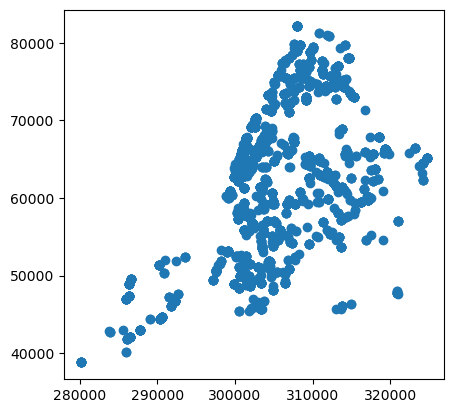

In [20]:
df_urgent_cleaned.plot()

## Notes



benefits over health facility genearl information:

- more complete (e.g., has urgent care)
- have more in-depth segmentation (instead of clinic, have type of clinic and what it actually does, which can inform whether a facility supports walk-ins), (desser + service types)
    - e.g., hospital extension clinics in hfgi include a methadone center, a dance injury center, and a dentistry center while in pnds, they are segmented into more identifying categories
- includes the number of providers (noprov)

cons versus health facility general information

- more complex (has a bunch of random, irrelevant stuff)
- indexed by health facilities & plans based on which plans contract with what facilities -- not directly comparable to healthcare accessibility without some tinkering

documentation: https://www.health.ny.gov/health_care/managed_care/docs/dictionary.pdf

what columns mean: https://www.opendatanetwork.com/dataset/health.data.ny.gov/eary-k6ia

To use this data, we need to assume the following:

1. The institutions that are involved in group medical insurance plans are representative of all relevant institutions.
    - this is somewhat reasonable since these institutions would be the most accessible to the average person
2. The assigned designated service is representative of what a facility actually does and can be used to determine whether a facility supports walk-ins or not
    - (can't guarantee that walk-ins are supported but can make generalizations like that clinics generally allow walk-ins)
3. Some subset of the data can be validly excluded, as it is not relevant to medical accessibility
    - should ideally exclude all medically tangential businesses while including relatively relevant ones (like urgent care)

Potential service codes to look for (that might support walk-ins)

- 005 state operated clinic
- 011 general hospital
- 034 state operated facility
- 150 pediatrics
- 252 primary care initiative in underserved areas
- 760 pharmacy?
- 776 general mpractice only - nospec?
- 777 all physician?
- 823 urgent care
- 899 hospital inpatient?
- 901 emergency room
- 914 general medicine - clinic speciality ?
- 978 preferred primary care clinic?
- clinic specialty things (have basically one for every field)